In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

In [32]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

In [33]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False

In [34]:
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

In [43]:
side = 10
t = 0
J = 1.0  
nstep = 50000
seed = 67  

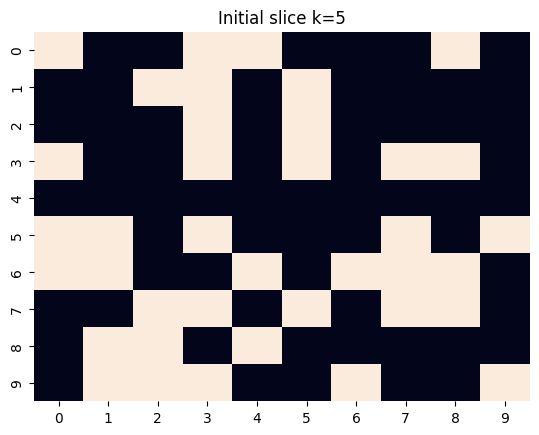

In [44]:
state = 2 * np.random.randint(2, size=(side, side, side)) - 1

mid = side // 2
sns.heatmap(state[:, :, mid], vmin=-1, vmax=1, cbar=False)
plt.title(f"Initial slice k={mid}")
plt.show()

In [45]:
e_old = energy(state, J)
e_history = []
m_history = []

rnd.seed(seed)

for istep in range(nstep):
    i = np.random.randint(side)
    j = np.random.randint(side)
    k = np.random.randint(side)

    flip(state, i, j, k)
    e_new = energy(state, J)

    if metropolis(e_old, e_new, t):
        e_old = e_new
    else:
        flip(state, i, j, k)  # undo flip

    e_history.append(e_old)
    m_history.append(magnetization(state))


/var/folders/cm/9hgr6tsn4nx0r2hqdh1_mt3h0000gn/T/ipykernel_50792/628714333.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  if np.random.random() < exp((e_old - e_new) / T):
/var/folders/cm/9hgr6tsn4nx0r2hqdh1_mt3h0000gn/T/ipykernel_50792/628714333.py:5: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.random() < exp((e_old - e_new) / T):


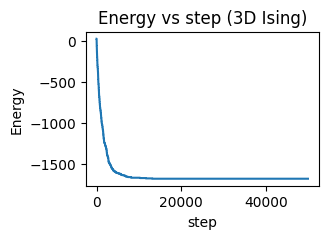

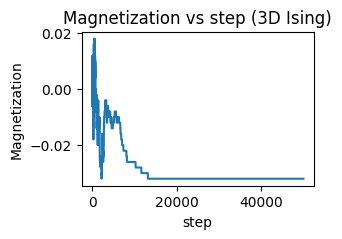

In [46]:
plt.figure(figsize=(3,2))
plt.plot(e_history)
plt.xlabel("step")
plt.ylabel("Energy")
plt.title("Energy vs step (3D Ising)")
plt.show()

plt.figure(figsize=(3,2))
plt.plot(m_history)
plt.xlabel("step")
plt.ylabel("Magnetization")
plt.title("Magnetization vs step (3D Ising)")
plt.show()

In [39]:
# discard first 1/3 of samples
cut = int(nstep/3)
e_sel = e_history[cut:]
m_sel = m_history[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -2214.3534282328587
Average magnetization: -0.8369612851935739
